In [1]:
# Import CVX and numpy libraries
import cvxpy as cvx
import numpy as np
import random
import matplotlib.pyplot as plt
from random import shuffle

In [2]:
def generate(n,npoints):
    # Set the limits
    origA = np.full((n+1,n),-5.)
    rangA = np.full((n+1,n), 10.)
    origP = np.full((npoints,n),-5.)
    rangP = np.full((npoints,n), 10.)

    # Construct the anchor points
    a = np.random.rand(n+1,n)
    a = origA + np.multiply(a,rangA)

    # Construct the sensor points
    p = np.random.rand(npoints,n)
    p = origP + np.multiply(p,rangP)

    adjacency = np.full((npoints+n+1,npoints+n+1),-1.)

    if(n > 1):
        minConstr = 3
        maxConstr = 4
        minPointConstr = 1
        minAnchConstr = 2
    else:
        minConstr = 2
        maxConstr = 3
        minPointConstr = 1
        minAnchConstr = 1

    anchList = [i for i in range(n+1)]
    pointList = [i for i in range(npoints)]
    off = n + 1

    for i in range(npoints):
        random.shuffle(anchList)
        random.shuffle(pointList)
        # Set anchor constraints, between 1 and 3
        numAnch = random.randint(minAnchConstr,minConstr)
        for l in range(numAnch):
            adjacency[anchList[l],i+off] = np.linalg.norm(a[anchList[l]] - p[i])
            adjacency[i+off,anchList[l]] = adjacency[anchList[l],i+off]
        print(numAnch)
        # Count number of constraints already set for this point
        countConstr = 0
        for l in range(npoints+off):
            if(adjacency[l,i+off] > 0):
                countConstr = countConstr + 1
        # Set point constraints, between 0 and 3
        if(minConstr - countConstr >= 0):
            numPoint = random.randint(minConstr-countConstr,3)
            count = numPoint
            l = 0
            while(count > 0 and l < len(pointList)):
                if(pointList[l] != i):
                        countConstr = 0
                        for k in range(npoints+off):
                            if(adjacency[k,pointList[l]+off] > 0):
                                countConstr = countConstr + 1
                        if(countConstr < maxConstr):
                            adjacency[pointList[l]+off,i+off] = np.linalg.norm(p[pointList[l]] - p[i])
                            adjacency[i+off,pointList[l]+off] = adjacency[pointList[l]+off,i+off]
                            count = count - 1
                l = l + 1
    return [a, p, adjacency]

In [49]:
# Function to solve for a specific block, given a beta
def solveXYBlock(Y, y_points, anchors, adjacency, n, npoints, beta):
    off = n + 1
    
    xlist = []
    for j in range(npoints):
        xlist.append(cvx.Variable(n))
        
    objfunc = 0 * cvx.Variable(1)
    constr  = 0 * cvx.Variable(n)
    
    for j in range(off,off+npoints):
        
        # Add the anchor constraints
        x_j = xlist[j-off]
        for k in range(off):
            if(adjacency[k,j] > 0.):
                objfunc += ((anchors[k]-x_j).T*(anchors[k]-y_points[j-off]) - adjacency[k,j]**2)**2
                
        # Add the point to point constraints
        for i in range(off,off+npoints):
            if(adjacency[i,j] > 0.):
                #d_ij
                x_i = xlist[i-off]
                objfunc += ((x_i - x_j).T * (y_points[i-off]-y_points[j-off]) - adjacency[i,j]**2)**2

        # Constraints
        constr += x_j - y_points[j-off]
        
    # Construct the problem
    objective = cvx.Minimize(objfunc \
                             - cvx.sum_entries(cvx.mul_elemwise(Y,constr)) \
                             + (beta / 2.) * cvx.norm(constr,2)**2)
    p = cvx.Problem(objective)

    # Solve
    result = p.solve()
    
    x = [xlist[i].value.A.flatten() for i in range(npoints)]
    
    return x

In [86]:
n = 2
npoints = 5
[a,p,adjacency]=generate(n,npoints)

3
2
3
2
2


Populating the interactive namespace from numpy and matplotlib


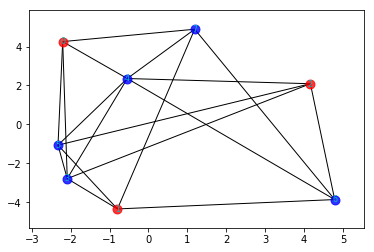

In [93]:
import matplotlib.pyplot as plt
import networkx as nx
%pylab inline --no-import-all
if(n == 2):
    G=nx.Graph()

    for i in range(n+1):
        G.add_node(i,pos=a[i])

    for i in range(npoints):
        G.add_node(n+1+i,pos=p[i])

    pos=nx.get_node_attributes(G,'pos')

    nx.draw_networkx_nodes(G,pos,
                           nodelist=[i for i in range(n+1)],
                           node_color='r',
                           node_size=80,
                           alpha=0.8,
                           with_labels=True)
    nx.draw_networkx_nodes(G,pos,
                           nodelist=[i for i in range(n+1,npoints+n+1)],
                           node_color='b',
                           node_size=80,
                           alpha=0.8,
                           with_labels=True)
    for i in range(npoints+n+1):
        for j in range(n+1,npoints+n+1):
            if(adjacency[j,i] > 0.):
                G.add_edge(i,j)

    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos,font_color='y',font_size=8)
    plt.draw()  # pyplot draw()

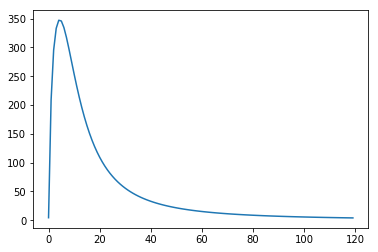

In [88]:
beta  = 0.5
niter = 600

Y = np.random.rand(n)

y_points = []
x_points = []
for j in range(npoints):
    y_points.append(np.random.rand(n))
    x_points.append(np.random.rand(n))

res = np.zeros(int(niter/5))

for it in range(niter):
    x_points = solveXYBlock(Y,y_points,a, adjacency,n,npoints,beta)
    y_points = solveXYBlock(Y,x_points,a, adjacency,n,npoints,beta)
    for j in range(npoints):
        Y -= beta*(x_points[j] - y_points[j])
    if(it % 5 == 0):
        res[int(it/5)] = np.dot(Y,Y)

plt.plot(range(res.size),res)
plt.show()

In [89]:
x_points

[array([-2.15401409, -2.93654571]),
 array([-0.68694763,  2.69307499]),
 array([-2.43237428, -1.11480842]),
 array([ 5.17641606, -4.39800589]),
 array([ 1.12165264,  5.33209892])]

In [90]:
p

array([[-2.08829627, -2.78878649],
       [-0.54506786,  2.35613685],
       [-2.32595169, -1.06866985],
       [ 4.78630027, -3.86622874],
       [ 1.1875406 ,  4.8899667 ]])